In [1]:
import hydra
import torch
from tqdm.notebook import tqdm
import time
from collections import defaultdict
from lib.utils.config import load_config
from lib.optimizer.framework import NeuralOptimizer
from lib.data.loader import load_intrinsics
from lib.data.loader import load_intrinsics
from lib.rasterizer import Rasterizer
from lib.renderer.renderer import Renderer
from lib.renderer.camera import Camera
from lib.tracker.timer import TimeTracker


def path_to_abblation(path):
    return "_".join(path.split("/")[-3].split("_")[1:])


def eval_iterations(optimizer, datamodule, mode: str= "backward", strategy: str="forward-mode"):
    tracker = TimeTracker()
    optimizer.max_iters = 1
    optimizer.max_optims = 1
    optimizer.optimizer.strategy=strategy

    # loop
    residuals = []
    for batch in datamodule.val_dataloader():
        batch = optimizer.transfer_batch_to_device(batch, "cuda", 0)
        tracker.start("step")
        if mode == "no_grad":
            with torch.no_grad():
                out = optimizer(batch)
        else:
            out = optimizer(batch)
        if mode == "backward":
            out["params"] = batch["init_params"]
            loss_info = optimizer.compute_loss(batch=batch, out=out)
            loss_info["loss"].backward()
        tracker.stop("step")
        residuals.append(out["optim_masks"][0].sum())
    return tracker, sum(residuals) / len(residuals)


def load_flame_renderer(scale):
    # instanciate similar to training
    cfg = load_config("train", ["data=debug"])
    K = load_intrinsics(data_dir=cfg.data.intrinsics_dir, return_tensor="pt")
    camera = Camera(
        K=K,
        width=cfg.data.width,
        height=cfg.data.height,
        near=cfg.data.near,
        far=cfg.data.far,
        scale=scale,
    )
    rasterizer = Rasterizer(width=camera.width, height=camera.height)
    renderer = Renderer(rasterizer=rasterizer, camera=camera)
    flame = hydra.utils.instantiate(cfg.model)
    return flame, renderer


def load_neural_optimizer(flame, renderer, path, override=[]):
    o = ["data=debug", "weighting=cnn", "regularize=dummy",  "optimizer.output_dir=none"] + override
    # o = ["data=debug", "optimizer.output_dir=none"] + override
    cfg = load_config("train", o)
    correspondence = hydra.utils.instantiate(cfg.correspondence)
    weighting = hydra.utils.instantiate(cfg.weighting)
    residuals = hydra.utils.instantiate(cfg.residuals)
    optimizer = hydra.utils.instantiate(cfg.optimizer)
    regularize = hydra.utils.instantiate(cfg.regularize)
    icp_optimizer = hydra.utils.instantiate(
        cfg.framework,
        flame=flame,
        logger=None,
        renderer=renderer,
        correspondence=correspondence,
        regularize=regularize,
        residuals=residuals,
        optimizer=optimizer,
        weighting=weighting,
    )
    return icp_optimizer.to("cuda")

# setup the datamodule
def load_datamodule(renderer, start_frame, end_frame):
    cfg = load_config("train", ["data=debug"])
    datamodule = hydra.utils.instantiate(
        cfg.data,
        renderer=renderer,
        val_dataset=dict(
            start_frame=start_frame,
            end_frame=end_frame,
        ),
    )
    datamodule.setup("fit")
    return datamodule

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import torch
from collections import defaultdict
from tqdm import tqdm

# Settings
start_frame = 10
end_frame = 12

# Checkpoints
ours = "/home/borth/GuidedResearch/checkpoints/synthetic_lr/ours2.ckpt"

# Loadings
times = defaultdict(dict)
residuals = defaultdict(dict)

for scale in tqdm([1,2,4,8,16]):  # 1, 17
    flame, renderer = load_flame_renderer(scale)
    datamodule = load_datamodule(renderer, start_frame, end_frame)
    optimizer = load_neural_optimizer(flame, renderer, ours)

    for mode in ["backward", "forward", "no_grad"]:
        for strategy in ["forward-mode", "reverse-mode"]:
            key = "fwAD" if strategy == "forward-mode" else "revAD"
            key += f"-{mode}"
            try:
                tracker, residual = eval_iterations(optimizer, datamodule, mode=mode, strategy=strategy)
                residuals[scale][key] = residual
                times[scale][key] = tracker.compute_statistics()["step"]["min"]
            except RuntimeError as e:
                print(f"CUDA out of memory error at scale {scale}, strategy {strategy}, {mode}.")
                torch.cuda.empty_cache()  # Free up GPU memory
                residuals[scale][key] = None
                times[scale][key] = None

# Save data
data = dict(times=dict(times), residuals=dict(residuals))
torch.save(data, "results/fwAD_revAD.pth")

  0%|          | 0/5 [00:00<?, ?it/s]

Creating GL context for cuda device 0
Successfully initialized EGL version 1.5
Successfully initialized OpenGL version 4.6.0 NVIDIA 535.183.01
CUDA out of memory error at scale 1, strategy reverse-mode, backward.
CUDA out of memory error at scale 1, strategy reverse-mode, forward.


 20%|██        | 1/5 [00:10<00:43, 10.90s/it]

CUDA out of memory error at scale 1, strategy reverse-mode, no_grad.
Creating GL context for cuda device 0
Successfully initialized EGL version 1.5
Successfully initialized OpenGL version 4.6.0 NVIDIA 535.183.01
CUDA out of memory error at scale 2, strategy reverse-mode, backward.
CUDA out of memory error at scale 2, strategy reverse-mode, forward.


 40%|████      | 2/5 [00:15<00:21,  7.12s/it]

CUDA out of memory error at scale 2, strategy reverse-mode, no_grad.
Creating GL context for cuda device 0
Successfully initialized EGL version 1.5
Successfully initialized OpenGL version 4.6.0 NVIDIA 535.183.01


/home/borth/miniconda3/envs/guided/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


CUDA out of memory error at scale 4, strategy reverse-mode, backward.
CUDA out of memory error at scale 4, strategy reverse-mode, forward.


 60%|██████    | 3/5 [00:28<00:19,  9.95s/it]

Creating GL context for cuda device 0
Successfully initialized EGL version 1.5
Successfully initialized OpenGL version 4.6.0 NVIDIA 535.183.01


 80%|████████  | 4/5 [00:34<00:08,  8.36s/it]

Creating GL context for cuda device 0
Successfully initialized EGL version 1.5
Successfully initialized OpenGL version 4.6.0 NVIDIA 535.183.01


100%|██████████| 5/5 [00:37<00:00,  7.54s/it]


In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

reverse_no_grad = {
    "method": "reverse_no_grad",
    "16x": 25.015,
    "8x": 82.966,
    "4x": 384.760,
    "2x": 0.0,
    "1x": 0.0,
}
reverse_grad = {
    "method": "reverse_grad",
    "16x": 27.698,
    "8x": 82.966,
    "4x": 477.149,
    "2x": 0.0,
    "1x": 0.0,
}
reverse_diff = {
    "method": "reverse_diff",
    "16x": 166.238,
    "8x": 0.0,
    "4x": 0.0,
    "2x": 0.0,
    "1x": 0.0,
}
forward_no_grad = {
    "method": "forward_no_grad",
    "16x": 11.612,
    "8x": 11.916,
    "4x": 14.858,
    "2x": 27.307,
    "1x": 75.879,
}
forward_grad = {
    "method": "forward_grad",
    "16x": 12.409,
    "8x": 12.446,
    "4x": 15.419,
    "2x": 27.481,
    "1x": 76.292,
}
forward_diff = {
    "method": "forward_diff",
    "16x": 45.590,
    "8x": 46.995,
    "4x": 54.543,
    "2x": 91.013,
    "1x": 243.967,
}
df = pd.DataFrame(
    [
        forward_no_grad,
        forward_grad,
        forward_diff,
        reverse_no_grad,
        reverse_grad,
        reverse_diff,
    ]
)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
mode = {
    "fwAD-no_grad": "fwAD w/o grad",
    "fwAD-forward": "fwAD w/ forward",
    "fwAD-backward": "fwAD w/ backward",
    "revAD-no_grad": "revAD w/o grad",
    "revAD-forward": "revAD w/ forward",
    "revAD-backward": "revAD w/ backward",
}
out = defaultdict(dict)
for scale, methods in data["times"].items():
    if scale not in [1,2,4,8,16]:
        continue
    for method in mode:
        value = methods[method]
        if value is None:
            value = 0.0
        out[method]["method"] = mode[method]
        out[method][f"{scale}x"] = value
out = dict(out)
df = pd.DataFrame(list(out.values()))
df

,method,1x,2x,4x,8x,16x
0,fwAD w/o grad,158.465,53.962,28.803,22.303,21.264
1,fwAD w/ forward,158.300,55.443,30.595,24.212,23.138
2,fwAD w/ backward,183.161,73.732,44.903,38.567,37.635
3,revAD w/o grad,0.000,0.000,396.850,102.743,35.955
4,revAD w/ forward,0.000,0.000,0.000,102.761,38.061
5,revAD w/ backward,0.000,0.000,0.000,117.590,51.961


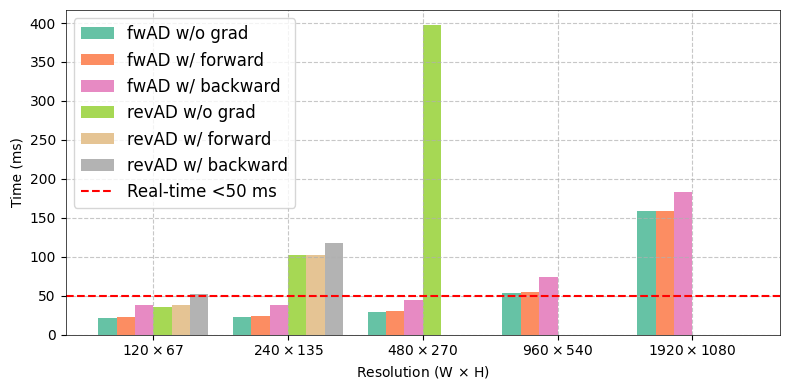

In [22]:
# Extracting method names and the x multipliers
methods = df["method"]
x_multipliers = ["16x", "8x", "4x", "2x", "1x"]

# Extracting the values for each multiplier
values = df[x_multipliers].values
# Set up the color map
colors = plt.get_cmap("Set2", 6)
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(8, 4))
# Adjust the linewidth of the box around the plot
ax.spines['top'].set_linewidth(0.5)    # Change the top spine thickness
ax.spines['right'].set_linewidth(0.5)  # Change the right spine thickness
ax.spines['left'].set_linewidth(0.5)   # Change the left spine thickness
ax.spines['bottom'].set_linewidth(0.5)  # Change the bottom spine thickness

# Number of bars per group
n_bars = len(df["method"])
# Set the width of the bars
bar_width = 0.15
# Set the spacing between groups
group_spacing = 0.2  # Adjust this value for more or less space between groups
# Set the positions of the bars with added spacing
bar_positions = np.arange(len(df.columns) - 1) * (n_bars * bar_width + group_spacing)
# Plotting each method as a separate bar
for i, (method, color) in enumerate(zip(df["method"], colors.colors)):
    pos = bar_positions + i * bar_width
    ax.bar(pos, values[i], bar_width, label=method, color=color)
# Adding x-ticks
ax.set_xticks(bar_positions + bar_width * (n_bars - 1) / 2)
# ax.set_xticklabels(["440 / (67x120)", "1794 / (135x240)", "7138 / (270x480)", "28636 / (540x960)", "115398 / (1080x1920)"])
ax.set_xticklabels([r"$120\times67$", r"$240\times135$", r"$480\times270$", r"$960\times540$", r"$1920\times1080$"])
# Adding labels and title
ax.set_xlabel(r"Resolution (W $\times$ H)")
ax.set_ylabel("Time (ms)")
# Adding a red line at 30ms
ax.axhline(y=50, color="red", linestyle="--")
# Adding a legend
legend_elements = plt.Line2D([0], [0], color="red", linestyle="--", label="Real-time <50 ms")
ax.legend(
    handles=ax.get_legend_handles_labels()[0] + [legend_elements],
    fontsize="12",
    loc="upper left",
)
# Adding grid for better readability
ax.grid(True, linestyle="--", alpha=0.7)
# Show the plot
plt.tight_layout()
plt.savefig("results/fwAD_revAD.pdf", format="pdf")
plt.show()